### Creating Feature Vectors - Between tuples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import word_definite as WD
from MatDB import *
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [3]:
import numpy as np
import math
np.set_printoptions(suppress=False, precision=16)

In [4]:
matDB = MatDB()

In [14]:
WD.word_definite_extInit(matDB)
# node2 = WD.word_definite('tIkzRam', 'tIkzRa', 31, 0, 0)
node1 = WD.word_definite('Adi', 'Adi', 31, 0, 0)
node2 = WD.word_definite('ca', 'ca', 2, 0, 1)
# node1 = WD.word_definite('koRam', 'koRa', 31, 0, 1)
print(node1)
print(node2)

feats = WD.Get_Features(node1, node2)
print(feats.shape)

443
WD_Node[C: 0, P: 0, Adi @(31) => Adi]
WD_Node[C: 1, P: 0, ca @(2) => ca]
(400, 1)


In [15]:
feats

array([[  6.7207201460977588],
       [ 25.                ],
       [  4.7319407373455329],
       [  5.2541498783830329],
       [  6.7207201460977588],
       [ 25.                ],
       [  5.2541498783830329],
       [  5.7485646877999379],
       [  6.3887402079420541],
       [  6.643440142781933 ],
       [  4.3576006752259451],
       [  4.4471216941305309],
       [ 25.                ],
       [ 25.                ],
       [  5.0736201334780358],
       [  5.0736201334780358],
       [ 25.                ],
       [ 25.                ],
       [  7.4926185018021734],
       [  8.4840792465447752],
       [ 25.                ],
       [  7.153055816608501 ],
       [  6.9597667469369933],
       [  9.1872170498421593],
       [ 25.                ],
       [  9.1940728356874839],
       [  6.1717123624255175],
       [  7.7175833409731922],
       [  8.5158689604253919],
       [  6.4098314733264319],
       [ 25.                ],
       [ 25.                ],
       [

In [7]:
matDB.mat_lemCount_1D['Adi']

195905

In [10]:
feats.nbytes/(1024*1024)

6.01953125

In [7]:
# for i in range(1335):
#     if feats[i] > 0:
#         print(i) 
# feats[-500:]

### Get PMI B/W Tuples

In [ ]:
# pmi(x;y) = -log2[p(x|y)/p(x)]
# def PMI(x, y, _pbModel):
#     # x : node1
#     # y : node2
#     if(x in _pbModel.fullCo_oc_mat[y]):
#         p_x_given_y = _pbModel.fullCo_oc_mat[y][x]/_pbModel.unigram_counts[y]
#         p_x = _pbModel.unigram_counts[x]/_pbModel.unigram_total_count
#         #print(p_x_given_y, ' ', p_x)
#         return -math.log2(p_x_given_y/p_x)
#     else:
#         p_x_given_y = 1/_pbModel.unigram_counts[y]
#         p_x = _pbModel.unigram_counts[x]/_pbModel.unigram_total_count
#         #print(p_x_given_y, ' ', p_x)
#         return -math.log2(p_x_given_y/p_x)

### Get tuple pairs for feature importance 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import word_definite as WD
from MatDB import *
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [3]:
import numpy as np
import math
np.set_printoptions(suppress=False, precision=16)

In [4]:
matDB = MatDB()

In [5]:
WD.word_definite_extInit(matDB)

443


In [6]:
len(matDB.mat_tupCount_1D)

217326

In [7]:
smallTupList = []
for tup1, val in matDB.mat_tupCount_1D.items():
    if val > 20:
        smallTupList.append(tup1)      

In [8]:
l = len(smallTupList)
print(l)

125596


In [9]:
batchCount = 10
perm = np.random.permutation(l)[:batchCount]
# perm2 = np.random.permutation(l)[:batchCount]

In [10]:
fN = 4*443**2 + 9*443 + 9
print(fN)

all_pairs = {}

index = 0
for k in range(batchCount):  
    tup1 = smallTupList[perm[k]]
    lem1 = tup1.split('_')
    cng1 = lem1[1]
    lem1 = lem1[0]
    
    node1 = WD.word_definite(None, lem1, cng1, 0, 0)
    for tup2, co_occurrence in matDB.mat_tup2tup_countonly[tup1].items():
        if co_occurrence > 4:
            lem2 = tup2.split('_')
            cng2 = lem2[1]
            lem2 = lem2[0]
            node2 = WD.word_definite(None, lem2, cng2, 0, 1)
            all_pairs[index] = (node1, node2)
            index += 1
            
print('Will get feature vectors for {} pairs'.format(index))
total_examples = index


788992
Will get feature vectors for 18 pairs


In [15]:
pairs_per_file = 10
for pairx in range(math.ceil(len(all_pairs)/pairs_per_file)):
    subset_pairs = range(pairx*pairs_per_file, min(len(all_pairs), (pairx + 1)*pairs_per_file))
    featureMatrix = np.zeros((fN, len(subset_pairs)))
    targetDict = {}
    index = 0
    current_pairs = {}
    for hi in subset_pairs:
        node1 = all_pairs[hi][0]
        node2 = all_pairs[hi][1]
        current_pairs[index] = '{}^{}'.format(node1.tup, node2.tup)
        featureMatrix[:, index, None] = WD.Get_Features(node1, node2)
        targetDict[index] = (matDB.mat_tup2tup_countonly[node1.tup][node2.tup],\
                              matDB.mat_lem2lem_countonly[node1.lemma][node2.lemma],\
                              matDB.mat_lem2tup_countonly[node1.lemma][node2.tup],\
                              matDB.mat_tup2lem_countonly[node1.tup][node2.lemma])
        index += 1
        if index % min(math.ceil(pairs_per_file/2), 100) == 0:
            print('Checkpoint S{}E{} of {}'.format(pairx, index, pairs_per_file))
    pickle.dump({'all_pairs': current_pairs, 'featureMatrix': featureMatrix, 'targetDict': targetDict},\
        open('outputs/featureSet_{}samples_8L_{}.p'.format(pairs_per_file, pairx), 'wb'), protocol = 4)

Checkpoint S0E5 of 10
Checkpoint S0E10 of 10
Checkpoint S1E5 of 10


In [4]:
featureBox = pickle.load(open('outputs/featureSet_10samples_8L_1.p', 'rb'))
print('All Pairs:')
display(featureBox['all_pairs'])
print('Feature Matrix:')
display(featureBox['featureMatrix'])
print('Target Dict(counts of word2word, lem2lem, lem2word, word2lem):')
display(featureBox['targetDict'])

All Pairs:


{0: 'vyaYjaka_3^sadBAva_169',
 1: 'vyaYjaka_3^evam_2',
 2: 'vyaYjaka_3^Adi_3',
 3: 'kalpa_99^vajra_3',
 4: 'kalpa_99^ca_2',
 5: 'kalpa_99^agni_3',
 6: 'kalpa_99^deva_3',
 7: 'kalpa_99^Sara_99'}

Feature Matrix:


array([[ 0.0051107325383305,  0.0051107325383305,  0.0119250425894378, ...,
         0.0023538026990271,  0.0017261219792865,  0.0006799874463856],
       [ 0.010221465076661 ,  0.0357751277683135,  0.0374787052810903, ...,
         0.039334658437075 ,  0.039334658437075 ,  0.0040799246783136],
       [ 0.0051107325383305,  0.0051107325383305,  0.0085178875638842, ...,
         0.0020922690658019,  0.0012030547128361,  0.0003138403598703],
       ..., 
       [ 0.                ,  0.                ,  0.                , ...,
         0.                ,  0.                ,  0.                ],
       [ 0.                ,  0.                ,  0.                , ...,
         0.                ,  0.                ,  0.                ],
       [ 0.                ,  0.                ,  0.                , ...,
         0.                ,  0.                ,  0.                ]])

Target Dict(counts of word2word, lem2lem, lem2word, word2lem):


{0: (6, 3, 3, 3),
 1: (5, 3, 3, 3),
 2: (5, 7, 5, 5),
 3: (6, 19, 19, 5),
 4: (18, 223, 222, 14),
 5: (14, 45, 40, 14),
 6: (6, 33, 23, 6),
 7: (6, 13, 6, 7)}

In [49]:
featureMatrix.shape

(788992, 2)

In [16]:
for key, val in all_pairs.items():
    all_pairs[key] = (val[0].tup, val[1].tup)

In [19]:
featureMatrix.nbytes/(1024*1024)

8595.890625

In [18]:
featureMatrix.shape

(788992, 1428)

In [21]:

pickle.dump({'all_pairs': all_pairs, 'featureMatrix': featureMatrix[:, 400:800], 'targetMatrix': targetMatrix},\
            open('outputs/featureSet_1428p_8L_1.p', 'wb'), protocol = 4)
pickle.dump({'all_pairs': all_pairs, 'featureMatrix': featureMatrix[:, 800:], 'targetMatrix': targetMatrix},\
            open('outputs/featureSet_1428p_8L_2.p', 'wb'), protocol = 4)

In [47]:
varVec = np.zeros((fN, 1))
meanVec = np.zeros((fN, 1))

In [48]:
for fk in range(fN):
    varVec[fk] = np.var(featureMatrix[fk, :])
    meanVec[fk] = np.mean(featureMatrix[fk, :])

In [68]:
fanoFactors = varVec/meanVec

d:\program files\anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [71]:
fanoFactors = fanoFactors[~np.isnan(fanoFactors)]
fanoFactors = fanoFactors[fanoFactors > 0.0025]

(array([ 10.,   1.,   1.,   2.,   0.,   3.,   2.,   1.,   0.,   1.]),
 array([ 0.0027130129321566,  0.0049483498450054,  0.0071836867578543,
         0.0094190236707031,  0.0116543605835519,  0.0138896974964008,
         0.0161250344092496,  0.0183603713220984,  0.0205957082349473,
         0.0228310451477961,  0.0250663820606449]),
 <a list of 10 Patch objects>)

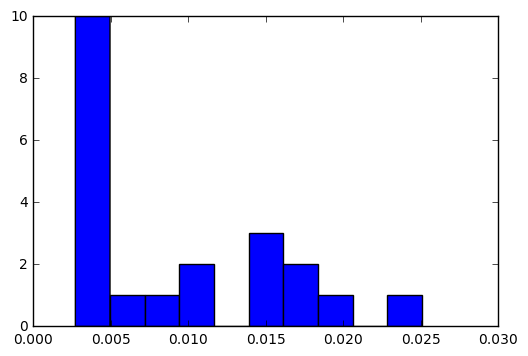

In [72]:
plt.hist(fanoFactors)

### Checking Features / Counting features

- Selecting Features and reducing size based on unique counts

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
np.set_printoptions(suppress=True)

In [40]:
folder = 'outputs/Features_of_10K_pairs/'
feat_fNames = [folder + fName for fName in os.listdir(folder)]

In [41]:
feat_unique_counts = np.array([0]*788992)
for feat_f in feat_fNames:
    %reset_selective -f featureSet
    featureSet = pickle.load(open(feat_f, 'rb'), encoding=u'utf8')
    print(featureSet.keys())
    len(featureSet['all_pairs'])
    featureSet['featureMatrix'].shape
    feat_unique_counts += np.apply_along_axis(lambda x: np.unique(x).shape[0], 1, featureSet['featureMatrix'])

dict_keys(['targetDict', 'all_pairs', 'featureMatrix'])
dict_keys(['targetDict', 'all_pairs', 'featureMatrix'])
dict_keys(['targetDict', 'all_pairs', 'featureMatrix'])


In [42]:
feat_unique_counts = np.floor(feat_unique_counts/len(feat_fNames)).astype(np.int32)

[ 536618.   66739.   52135.   34810.   27158.   19792.   17101.   13302.
   12554.    6278.    2255.     250.]


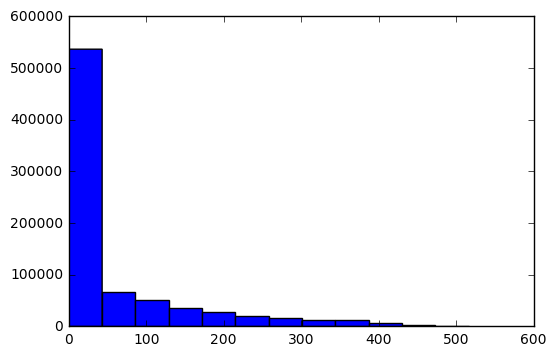

In [43]:
hist_with_binsize = lambda v, binsize: plt.hist(v, bins=range(0, max(v) + binsize, binsize))
what1, what2, _ = hist_with_binsize(feat_unique_counts, 43)
print(what1)

In [44]:
what2

array([  0,  43,  86, 129, 172, 215, 258, 301, 344, 387, 430, 473, 516])

In [48]:
select_features = np.where(feat_unique_counts >= 430)[0]
print(select_features.shape)

(2505,)


In [39]:
# feat_unique_counts

In [49]:
featureSet['featureMatrix'].shape

(788992, 500)

In [50]:
mat_cngCount_1D = pickle.load(open('../NewData/gauravs/Temporary_1D/mat_cngCount_1D.p', 'rb'), encoding = u'utf-8')

In [51]:
_full_cnglist = list(mat_cngCount_1D)
_cg_count = len(mat_cngCount_1D)

In [52]:
feats = {}
fIndex = 0
feats[fIndex] = ('L', 'L'); fIndex += 1;
feats[fIndex] = ('L', 'C'); fIndex += 1;
feats[fIndex] = ('L', 'T'); fIndex += 1;

feats[fIndex] = ('C', 'L'); fIndex += 1;
feats[fIndex] = ('C', 'C'); fIndex += 1;
feats[fIndex] = ('C', 'T'); fIndex += 1;

feats[fIndex] = ('T', 'L'); fIndex += 1;
feats[fIndex] = ('T', 'C'); fIndex += 1;
feats[fIndex] = ('T', 'T'); fIndex += 1;

# Path Constraint - Length 2 - # _cg_count

# LEMMA->CNG->LEMMA
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('lem', cng_k, 'lem')
fIndex += _cg_count

# LEMMA->CNG->CNG
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('lem', cng_k, 'cng')
fIndex += _cg_count

# LEMMA->CNG->TUP
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('lem', cng_k, 'tup')
fIndex += _cg_count

# CNG->CNG->LEMMA
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('cng', cng_k, 'lem')
fIndex += _cg_count

# CNG->CNG->CNG
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('cng', cng_k, 'cng')
fIndex += _cg_count

# CNG->CNG->TUP
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('cng', cng_k, 'tup')
fIndex += _cg_count

# TUP->CNG->LEMMA :: TOO MANY ZEROS
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('tup', cng_k, 'lem')
fIndex += _cg_count

# TUP->CNG->CNG :: TOO MANY ZEROS
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('tup', cng_k, 'cng')
fIndex += _cg_count

# TUP->CNG->TUP :: TOO MANY ZEROS
for k in range(0, _cg_count):
    cng_k = _full_cnglist[k]
    feats[fIndex + k] = ('tup', cng_k, 'tup')
fIndex += _cg_count

# Path Constraint - Length 3 - # _cg_count^2

# LEMMA->CGS->CGS->LEMMA
for k1 in range(0, _cg_count):
    cng_k1 = _full_cnglist[k1]
    for k2 in range(0, _cg_count): 
        cng_k2 = _full_cnglist[k2]
        feats[fIndex + k1*_cg_count + k2] = ('L', cng_k1, cng_k2, 'L')
fIndex += _cg_count**2

# LEMMA->CGS->CGS->TUP
for k1 in range(0, _cg_count):
    cng_k1 = _full_cnglist[k1]
    for k2 in range(0, _cg_count): 
        cng_k2 = _full_cnglist[k2]
        feats[fIndex + k1*_cg_count + k2] = ('L', cng_k1, cng_k2, 'T')
fIndex += _cg_count**2

# TUP->CGS->CGS->LEM
for k1 in range(0, _cg_count):
    cng_k1 = _full_cnglist[k1]
    for k2 in range(0, _cg_count): 
        cng_k2 = _full_cnglist[k2]
        feats[fIndex + k1*_cg_count + k2] = ('T', cng_k1, cng_k2, 'L')
fIndex += _cg_count**2

# TUP->CGS->CGS->TUP
for k1 in range(0, _cg_count):
    cng_k1 = _full_cnglist[k1]
    for k2 in range(0, _cg_count): 
        cng_k2 = _full_cnglist[k2]
        feats[fIndex + k1*_cg_count + k2] = ('T', cng_k1, cng_k2, 'T')
fIndex += _cg_count**2

In [53]:
for key in list(feats.keys()):
    if key not in select_features:
        feats.pop(key)

In [26]:
# select_feat_names

In [54]:
pickle.dump(feats, open('outputs/selected_feats.p', 'wb'))

In [55]:
folder = 'outputs/Features_of_10K_pairs/'
feat_fNames = os.listdir(folder)

feat_unique_counts = np.array([0]*788992)
for feat_f in feat_fNames:
    %reset_selective -f featureSet
    featureSet = pickle.load(open(folder + feat_f, 'rb'), encoding=u'utf8')
    featureSet['featureMatrix'] = featureSet['featureMatrix'][select_features, :] 
    pickle.dump(featureSet, open('outputs/Features_of_10K_reduced/' + feat_f, 'wb') )

### Further reduce size of feature vectors

- Use the earlier created reduced set feature vectors

#### Put together the feature matrices into single file

In [56]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import re
%matplotlib inline

In [64]:
folder = 'outputs/Features_of_10K_reduced/'
feat_fNames = os.listdir(folder)
print(feat_fNames)

['featureSet_500samples_8L_0.p', 'featureSet_500samples_8L_1.p', 'featureSet_500samples_8L_10.p', 'featureSet_500samples_8L_11.p', 'featureSet_500samples_8L_12.p', 'featureSet_500samples_8L_13.p', 'featureSet_500samples_8L_14.p', 'featureSet_500samples_8L_15.p', 'featureSet_500samples_8L_16.p', 'featureSet_500samples_8L_17.p', 'featureSet_500samples_8L_18.p', 'featureSet_500samples_8L_19.p', 'featureSet_500samples_8L_2.p', 'featureSet_500samples_8L_3.p', 'featureSet_500samples_8L_4.p', 'featureSet_500samples_8L_5.p', 'featureSet_500samples_8L_6.p', 'featureSet_500samples_8L_7.p', 'featureSet_500samples_8L_8.p', 'featureSet_500samples_8L_9.p']


In [58]:
select_feat_names = pickle.load(open('outputs/selected_feats.p', 'rb'))
print(len(select_feat_names.keys()))

2505


In [59]:
featureMatrix = np.ndarray((20*500, len(select_feat_names)))
targetDict = np.ndarray((20*500, 4))
all_pairs = []

In [63]:
start_i = 0
for feat_f in feat_fNames:
    %reset_selective -f featureSet
    featureSet = pickle.load(open(folder + feat_f, 'rb'), encoding=u'utf8')
    print(featureSet['featureMatrix'].shape)
    featureMatrix[start_i:(start_i + featureSet['featureMatrix'].shape[1]), :] = featureSet['featureMatrix'].transpose()    
    for k in featureSet['targetDict'].keys():
        targetDict[start_i + k, :] = featureSet['targetDict'][k]
    
    start_i += featureSet['featureMatrix'].shape[1]
    all_pairs.extend(featureSet['all_pairs'])
    

(2505, 500)
(2505, 500)
(2066, 500)


ValueError: could not broadcast input array from shape (500,2066) into shape (500,2505)

In [6]:
featureMatrix.shape

(10000, 2066)

#### Feature selection using sklearn.feature_selection package

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [152]:
# manual testing of feature selection
# featureMatrix = np.random.random_integers(0, 10, (4000, 3))
# targetDict = np.ndarray((4, 4))
# targetDict = featureMatrix[:, 1] - 2*np.power(featureMatrix[:, 2], 2)

In [228]:
# Used mutual_info_regression for selecting features as it can capture non-linear relationships also
select_feats = SelectKBest(mutual_info_regression, k = 10).fit_transform(featureMatrix, targetDict[:, 0])

In [229]:
select_feats

array([[  2.54617137e-07,   7.11068157e-07,   1.17670091e-07, ...,
          4.41429280e-07,   6.45403096e-09,   1.66537250e-08],
       [  5.91075496e-06,   1.76107880e-05,   2.73162712e-06, ...,
          1.51034481e-06,   1.49825719e-07,   3.86604329e-07],
       [  5.00031683e-04,   1.60552079e-03,   2.31087249e-04, ...,
          1.94746924e-04,   1.26747948e-05,   3.27055367e-05],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

#### Choose top 400 features based on Mutual Information between 8L features and each of the target variables

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
import pandas as pd

In [ ]:
# estimator = RandomForestRegressor(random_state=0, n_estimators=20)

In [10]:
# Get Mutual information of the feature matrix with each of target values individually
# Then take top 100 features from each individual MI- estimator
mi_with_t2t = mutual_info_regression(featureMatrix, targetDict[:, 0])
mi_with_l2l = mutual_info_regression(featureMatrix, targetDict[:, 1])
mi_with_l2t = mutual_info_regression(featureMatrix, targetDict[:, 2])
mi_with_t2l = mutual_info_regression(featureMatrix, targetDict[:, 3])

In [17]:
# Save the goddamn MI results
# backup = {}
# backup['mi_with_t2t'] = mi_with_t2t
# backup['mi_with_l2l'] = mi_with_l2l
# backup['mi_with_l2t'] = mi_with_l2t
# backup['mi_with_t2l'] = mi_with_t2l
# pickle.dump(backup, open('outputs/mi_backup.p', 'wb'))

AttributeError: 'dict' object has no attribute 'close'

In [18]:
# Print Range of Mutual Information
print_range = lambda x: print('Range: {}->{}'.format(np.min(x), np.max(x)))
print_range(mi_with_t2t)
print_range(mi_with_l2l)
print_range(mi_with_l2t)
print_range(mi_with_t2l)

Range: 0.03492575930544639->0.10393728375766376
Range: 0.07728130465388539->1.1413320587224174
Range: 0.13472137926405647->0.3893874906056336
Range: 0.08366905158374571->1.0214233508646107


In [24]:
# Choose top 100 from each MI - top_400_local"local index"
top_100_t2t = np.argsort(mi_with_t2t)[-116:]
print(mi_with_t2t[top_100_t2t])
top_100_l2l = np.argsort(mi_with_l2l)[-116:]
top_100_l2t = np.argsort(mi_with_l2t)[-114:]
top_100_t2l = np.argsort(mi_with_t2l)[-116:]

top_400_local = np.concatenate([top_100_t2t, top_100_l2l, top_100_l2t, top_100_t2l])
top_400_local = np.unique(top_400_local)
print(top_400_local.shape)
# print(top_400)

(400,)


In [25]:
# Convert top_400_local"local index" to "Actual feature index" :: This will only hold for 8L setup
sevenL_keys_ordered = sorted(select_feat_names.keys())
top_400_global = []
for i in top_400_local:
    top_400_global.append(sevenL_keys_ordered[i])
# print(top_400_global)

with open('outputs/top_400_featureCode.txt', 'w') as f_handle:
    for i in top_400_global:
#         print(i, ': ', select_feat_names[i])
        if len(select_feat_names[i]) == 3:
            left = select_feat_names[i][0]
            center = select_feat_names[i][1]
            right = select_feat_names[i][2]
            left = left.replace('lem', 'L')
            left = left.replace('cng', 'C')
            left = left.replace('tup', 'T')

            right = right.replace('lem', 'L')
            right = right.replace('cng', 'C')
            right = right.replace('tup', 'T')
            f_handle.write('{},{},{}\n'.format(left, center, right))
        else:
            f_handle.write('{},{},{},{}\n'.format(select_feat_names[i][0],
                                               select_feat_names[i][1],
                                               select_feat_names[i][2],
                                               select_feat_names[i][3],
                                              ))

#### Generate Hard-Code for 'GetFeature()' function

In [26]:
import re

In [58]:
with open('outputs/top_400_featureCode.txt') as f_handle:
    gen_code_handle = open('GetFeatures_gen.py', 'w')
    gen_code_handle.write('''
def Get_Features(node1, node2):
    feats = np.zeros((_edge_vector_dim, 1))
    fIndex = 0
    ''')
    for line in f_handle:
        line = line.strip()
        opts = re.split(',', line)
        converter = {
            'L': 'lemma',
            'C': 'cng',
            'T': 'tup'
        }
        left_mats = {
            'L': 'mat_lem2cng_countonly',
            'C': 'mat_cng2cng_countonly',
            'T': 'mat_tup2cng_countonly'
        }
        right_mats = {
            'L': 'mat_cng2lem_countonly',
            'C': 'mat_cng2cng_countonly',
            'T': 'mat_cng2tup_countonly'
        }
        left_1D = {
            'L': 'mat_lemCount_1D',
            'C': 'mat_cngCount_1D',
            'T': 'mat_tupCount_1D'
        }
        if len(opts) == 3:
            left = opts[0]
            right = opts[2]
            gen_code_handle.write('''
    # {}->{}->{}
    pleft = tryProb_catchZero({}, {}, node1.{}, \'{}\')
    pright = tryProb_catchZero({}, mat_cngCount_1D, \'{}\', node2.{})
    feats[fIndex] = pleft * pright; fIndex += 1
            '''.format(opts[0], opts[1], opts[2], left_mats[left], left_1D[left], converter[left], opts[1],
                      right_mats[right], opts[1], converter[right]))
        elif len(opts) == 4:
            left = opts[0]
            right = opts[3]
            cng_1 = opts[1]
            cng_2 = opts[2]
            gen_code_handle.write('''
    # {} -> {} -> {} -> {}
    pleft = tryProb_catchZero({}, {}, node1.{}, \'{}\')
    pmid = tryProb_catchZero(mat_cng2cng_countonly, mat_cngCount_1D, \'{}\', \'{}\')
    pright = tryProb_catchZero({}, mat_cngCount_1D, \'{}\', node2.{})
    feats[fIndex] = pleft * pmid * pright; fIndex += 1
    '''.format(opts[0], opts[1], opts[2], opts[3], left_mats[left], left_1D[left], converter[left], cng_1,
                       cng_1, cng_2,
                       right_mats[right], cng_2, converter[right]))
    gen_code_handle.write('''
    feats[feats < 1e-25] = 1e-25
    return -np.log10(feats)
    ''')
    gen_code_handle.close()